In [0]:
# Для работы в колабе
try:
  from google.colab import files
  google_colab = True
except Exception:
  google_colab = False
  print('Working not in colab')
import os
import pandas as pd
import numpy as np

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
# Путь к директории с данным
if google_colab:
  path = "drive/My Drive/hack/changelenge/final/"
else:
  path = './'

In [0]:
if google_colab:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# loading train data to DataFrame
train_df = pd.read_csv(path + "CL_megafon_Cup IT_2020_final_data.csv",
                       comment='#', sep=';')

## Посмотрим на данные и проведем первичный анализ


In [0]:
train_df.head()

,time_start,time_end,place_latitude,place_longitude
0,2019-08-24 14:23:56,2019-08-24 18:54:47,28.102908,113.617867
1,2018-06-19 08:56:22,2018-06-19 12:15:26,28.102908,113.617867
2,2018-08-29 14:00:32,2018-08-29 14:37:51,28.102908,113.617867
3,2019-12-10 16:01:26,2019-12-10 16:35:22,28.102908,113.617867
4,2019-12-10 13:39:42,2019-12-10 17:58:22,28.999495,115.167583


## Обработка данных

In [0]:
# Преобразуем данные во временной формат
train_df.time_start = pd.to_datetime(train_df.time_start)
train_df.time_end = pd.to_datetime(train_df.time_end)
train_df.dtypes

time_start         datetime64[ns]
time_end           datetime64[ns]
place_latitude            float64
place_longitude           float64
dtype: object

In [0]:
# Сгенерируем целевую переменную
train_df['service_time'] = train_df.time_end - train_df.time_start

In [0]:
train_df['service_time_minutes'] = train_df['service_time']\
                                    .apply(lambda time:
                                           time.total_seconds() / 60)

In [0]:
# Проверим правильно ли сгенерировалась фича
train_df.head()

,time_start,time_end,place_latitude,place_longitude,service_time,service_time_minutes
0,2019-08-24 14:23:56,2019-08-24 18:54:47,28.102908,113.617867,04:30:51,270.850000
1,2018-06-19 08:56:22,2018-06-19 12:15:26,28.102908,113.617867,03:19:04,199.066667
2,2018-08-29 14:00:32,2018-08-29 14:37:51,28.102908,113.617867,00:37:19,37.316667
3,2019-12-10 16:01:26,2019-12-10 16:35:22,28.102908,113.617867,00:33:56,33.933333
4,2019-12-10 13:39:42,2019-12-10 17:58:22,28.999495,115.167583,04:18:40,258.666667


Колонка коорд понадобится для более удобной кластеризации и поиска уникальных пар координат через unique()

In [0]:
# Создадим колонку для координат формата (широта, долгота)
train_df['coord'] = train_df.index
train_df['coord'] = train_df['coord']\
                      .apply(lambda x:
                             (train_df.place_longitude[x],
                              train_df.place_latitude[x],))
point_coords = train_df.coord.unique()

In [0]:
# Отсортируем данные для наглядности и удобства
train_df = train_df.sort_values(['coord', 'time_start'])

#### Проверка на NaN

In [0]:
train_df.isna().sum()

time_start              0
time_end                0
place_latitude          0
place_longitude         0
service_time            0
service_time_minutes    0
coord                   0
dtype: int64

Роскошно нанов нет

### Вывод координат на карту

In [0]:
# Установка/импорт карт
try:
  from mpl_toolkits.basemap import Basemap
except Exception:
  !apt-get install libgeos-3.5.0
  !apt-get install libgeos-dev
  !pip install https://github.com/matplotlib/basemap/archive/master.zip
  from mpl_toolkits.basemap import Basemap

Ого, да это Китай

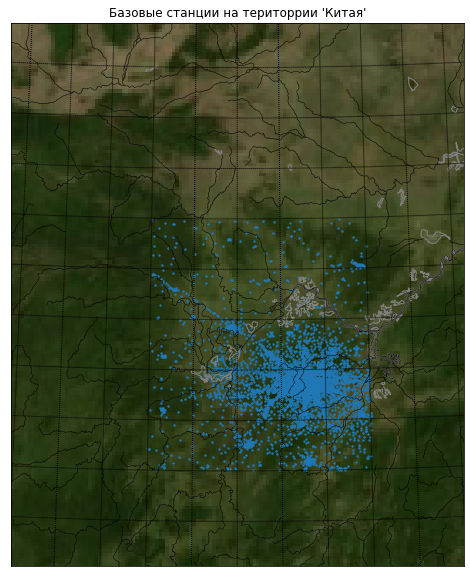

In [0]:
# Draw our points on map, it is square 5x5 degrees
fig = plt.figure(figsize=(15,10))

map = Basemap(width=1E6,
              height=1.2E6,
              projection='lcc',
              lat_0=30.5,
              lon_0=113,
              resolution='h')
map.shadedrelief()
map.drawcoastlines(color='gray')
map.drawcountries(color='gray')
map.drawrivers()

map.drawmeridians(np.arange(0,360,1))
map.drawparallels(np.arange(-90,90,1))
map.bluemarble()
lon = [coord[0] for coord in point_coords]
lat = [coord[1] for coord in point_coords]
map.scatter(lon, lat, latlon=True, s=2)
plt.title('Базовые станции на територрии \'Китая\'')
plt.show()

## Генерация фичей

In [0]:
# Dataframe в данный момент
train_df.head(5)

,time_start,time_end,place_latitude,place_longitude,service_time,service_time_minutes,coord
26632,2018-03-12 14:24:43,2018-03-12 17:26:54,31.96447,111.01,03:02:11,182.183333,"(111.01, 31.964470000000002)"
26640,2018-03-30 09:16:33,2018-03-30 10:33:58,31.96447,111.01,01:17:25,77.416667,"(111.01, 31.964470000000002)"
26609,2018-07-24 10:18:12,2018-07-24 11:05:42,31.96447,111.01,00:47:30,47.500000,"(111.01, 31.964470000000002)"
26612,2018-07-25 15:25:34,2018-07-25 16:22:57,31.96447,111.01,00:57:23,57.383333,"(111.01, 31.964470000000002)"
26613,2018-09-19 11:57:56,2018-09-19 13:09:44,31.96447,111.01,01:11:48,71.800000,"(111.01, 31.964470000000002)"


### Добавление признаков связавнных с координатами

#### Добавление часового пояса
Бесполезно, здесь для красоты

In [0]:
# Импорт/установка библиотеки с часовыми поясами
try:
  from timezonefinder import TimezoneFinder
except Exception:
  !pip install timezonefinder
  from timezonefinder import TimezoneFinder

In [0]:
tf = TimezoneFinder()
# Example from docs
longitude = point_coords[0][0]
latitude = point_coords[0][1]
tf.timezone_at(lng=longitude, lat=latitude) # returns 'Europe/Berlin'

'Asia/Shanghai'

In [0]:
train_df['timezone'] = train_df['coord']\
                        .apply(lambda x:
                               tf.timezone_at(lng=x[0], lat=x[1]))

In [0]:
train_df.timezone.unique()

array(['Asia/Shanghai'], dtype=object)

Везде один и тот же часовой пояс, значит это бесполезный признак, к сожалению, переходим ко времени

In [0]:
train_df = train_df.drop('timezone', axis=1)

### Добавление признаков связанных со временем

#### Добавим времена года
Сделаем категориальный признак в виде сезона:
  1. Зима
  2. Весна
  3. Лето
  4. Осень

In [0]:
seasons_dict = {
    1: [12, 1, 2], # winter
    2: range(3, 6), # spring
    3: range(6, 9), # summer time sadness
    4: range(9, 12) # autumn
}
def get_season(month):
  for season, gap in seasons_dict.items():
    if month in gap:
      return season
  return -1

In [0]:
def add_season_column(df):
  df['season'] = df['time_start']\
                    .apply(lambda x: get_season(x.month))
add_season_column(train_df)

In [0]:
train_df.head(5)

,time_start,time_end,place_latitude,place_longitude,service_time,service_time_minutes,coord,season
26632,2018-03-12 14:24:43,2018-03-12 17:26:54,31.96447,111.01,03:02:11,182.183333,"(111.01, 31.964470000000002)",2
26640,2018-03-30 09:16:33,2018-03-30 10:33:58,31.96447,111.01,01:17:25,77.416667,"(111.01, 31.964470000000002)",2
26609,2018-07-24 10:18:12,2018-07-24 11:05:42,31.96447,111.01,00:47:30,47.500000,"(111.01, 31.964470000000002)",3
26612,2018-07-25 15:25:34,2018-07-25 16:22:57,31.96447,111.01,00:57:23,57.383333,"(111.01, 31.964470000000002)",3
26613,2018-09-19 11:57:56,2018-09-19 13:09:44,31.96447,111.01,01:11:48,71.800000,"(111.01, 31.964470000000002)",4


#### Добавления колонки для ночи
Колонка сообщающая о происшествии в ночное время

In [0]:
daytime_dict = {
    1: list(range(22, 25)) + list(range(7)), # It's nighttime
}
def get_daytime(hour):
  if hour in daytime_dict[1]:
    return 1
  return 0

In [0]:
def add_night_column(df):
  df['night_time'] = df['time_start']\
                            .apply(lambda x: get_daytime(x.hour))
add_night_column(train_df)

In [0]:
train_df.head()

,time_start,time_end,place_latitude,place_longitude,service_time,service_time_minutes,coord,season,night_time
26632,2018-03-12 14:24:43,2018-03-12 17:26:54,31.96447,111.01,03:02:11,182.183333,"(111.01, 31.964470000000002)",2,0
26640,2018-03-30 09:16:33,2018-03-30 10:33:58,31.96447,111.01,01:17:25,77.416667,"(111.01, 31.964470000000002)",2,0
26609,2018-07-24 10:18:12,2018-07-24 11:05:42,31.96447,111.01,00:47:30,47.500000,"(111.01, 31.964470000000002)",3,0
26612,2018-07-25 15:25:34,2018-07-25 16:22:57,31.96447,111.01,00:57:23,57.383333,"(111.01, 31.964470000000002)",3,0
26613,2018-09-19 11:57:56,2018-09-19 13:09:44,31.96447,111.01,01:11:48,71.800000,"(111.01, 31.964470000000002)",4,0


#### Добавление колонки с номером часа начала сбоя

In [0]:
def add_hour_start_column(df):
  df['hour_start'] = df['time_start'].apply(lambda x: x.hour)
add_hour_start_column(train_df)

In [0]:
train_df.head()

,time_start,time_end,place_latitude,place_longitude,service_time,service_time_minutes,coord,season,night_time,hour_start
26632,2018-03-12 14:24:43,2018-03-12 17:26:54,31.96447,111.01,03:02:11,182.183333,"(111.01, 31.964470000000002)",2,0,14
26640,2018-03-30 09:16:33,2018-03-30 10:33:58,31.96447,111.01,01:17:25,77.416667,"(111.01, 31.964470000000002)",2,0,9
26609,2018-07-24 10:18:12,2018-07-24 11:05:42,31.96447,111.01,00:47:30,47.500000,"(111.01, 31.964470000000002)",3,0,10
26612,2018-07-25 15:25:34,2018-07-25 16:22:57,31.96447,111.01,00:57:23,57.383333,"(111.01, 31.964470000000002)",3,0,15
26613,2018-09-19 11:57:56,2018-09-19 13:09:44,31.96447,111.01,01:11:48,71.800000,"(111.01, 31.964470000000002)",4,0,11


#### Добавление колонки выходного дня

In [0]:
# holidays import
try:
  import holidays
except Exception:
  !pip install holidays
  import holidays

In [0]:
# Используем Российские праздники
ru_holidays = holidays.RU()

In [0]:
def is_holiday(date):
  if date in ru_holidays or date.dayofweek == 6:
    return 1
  return 0

In [0]:
def add_holiday_column(df):
  df['holiday'] = df['time_start'].apply(lambda x: is_holiday(x))
add_holiday_column(train_df)

In [0]:
# Вуаля
train_df.head()

,time_start,time_end,place_latitude,place_longitude,service_time,service_time_minutes,coord,season,night_time,hour_start,holiday
26632,2018-03-12 14:24:43,2018-03-12 17:26:54,31.96447,111.01,03:02:11,182.183333,"(111.01, 31.964470000000002)",2,0,14,0
26640,2018-03-30 09:16:33,2018-03-30 10:33:58,31.96447,111.01,01:17:25,77.416667,"(111.01, 31.964470000000002)",2,0,9,0
26609,2018-07-24 10:18:12,2018-07-24 11:05:42,31.96447,111.01,00:47:30,47.500000,"(111.01, 31.964470000000002)",3,0,10,0
26612,2018-07-25 15:25:34,2018-07-25 16:22:57,31.96447,111.01,00:57:23,57.383333,"(111.01, 31.964470000000002)",3,0,15,0
26613,2018-09-19 11:57:56,2018-09-19 13:09:44,31.96447,111.01,01:11:48,71.800000,"(111.01, 31.964470000000002)",4,0,11,0


#### Функция для добавление всех временных фичей

In [0]:
# Для тестовых данных
def add_time_features(df):
  add_season_column(df)
  add_night_column(df)
  add_hour_start_column(df)
  add_holiday_column(df)

## Предобработка данных

#### Избавимся от выбросов

In [0]:
# В качестве границы возьмем 96 процентиль
time_threshold = train_df.service_time.quantile(0.96)
time_threshold

Timedelta('1 days 05:43:24.199999')

In [0]:
pd.Timedelta('1 days 05:43:24.199999').seconds / 60

343.4

In [0]:
# Оибросим все значения которые больше 96 процентиля
train_df_mod = train_df[train_df['service_time'] < time_threshold]
print("Удалено экземпляров:", train_df.shape[0] - train_df_mod.shape[0])

Удалено экземпляров: 3129


### Избавимся от ненужных колонок

In [0]:
# Датасет в здании
train_df_mod.drop(['time_end', 'service_time'], axis=1, inplace=True)
train_df_mod.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,time_start,place_latitude,place_longitude,service_time_minutes,coord,season,night_time,hour_start,holiday
26632,2018-03-12 14:24:43,31.96447,111.01,182.183333,"(111.01, 31.964470000000002)",2,0,14,0
26640,2018-03-30 09:16:33,31.96447,111.01,77.416667,"(111.01, 31.964470000000002)",2,0,9,0
26609,2018-07-24 10:18:12,31.96447,111.01,47.500000,"(111.01, 31.964470000000002)",3,0,10,0
26612,2018-07-25 15:25:34,31.96447,111.01,57.383333,"(111.01, 31.964470000000002)",3,0,15,0
26613,2018-09-19 11:57:56,31.96447,111.01,71.800000,"(111.01, 31.964470000000002)",4,0,11,0


### Добавление ручной и очень хитрой группировки
Фича Богдана

In [0]:
df_loc = train_df_mod[['time_start', 'place_latitude', 'place_longitude']]

In [0]:
df_loc['time_start'] = df_loc['time_start'].apply(lambda x: x.floor('MIN'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
new = df_loc['time_start'].value_counts()
new = new.to_frame()
new.rename(columns=({'time_start':'count'}), inplace=True)

In [0]:
new['time_start'] = new.index

In [0]:
df_loc = pd.merge(df_loc, new, on='time_start', how='left')

In [0]:
len(df_loc.query('count != 1')['time_start'].unique())

8086

In [0]:
df_loc_groups = df_loc.query('count > 2')

In [0]:
cl = len(df_loc_groups.time_start.unique())

In [0]:
df_loc.sort_values(by='count', ascending=False).head(5)

,time_start,place_latitude,place_longitude,count
9194,2019-08-07 02:25:00,29.858603,112.895050,18
6754,2019-08-07 02:25:00,29.829378,112.634167,18
6672,2019-08-07 02:25:00,29.743636,112.620260,18
9479,2019-08-07 02:25:00,29.815033,112.905272,18
9281,2019-08-07 02:25:00,29.824883,112.902180,18


In [0]:
new = df_loc[['time_start','count']].groupby(by='time_start').count().sort_values('count', ascending=False)
new['id'] = [i for i in range(new.shape[0])]
new.head(5)

,count,id
time_start,,
2019-08-07 02:25:00,18,0
2018-12-16 21:35:00,16,1
2019-05-25 03:24:00,15,2
2018-09-28 08:15:00,14,3
2018-09-28 18:37:00,14,4


In [0]:
df_numed = pd.merge(df_loc, new[['id']], how='left', on='time_start').sort_values('count', ascending=False)

In [0]:
df_numed.groupby(by=['place_latitude', 'place_longitude']).agg({'id': 'min',
                                                                'time_start': 'count'})#.min().sort_values('id', ascending=True)

,,id,time_start
place_latitude,place_longitude,,
27.002889,115.390675,1005,12
27.004426,114.508818,5938,9
27.004441,114.482340,7057,17
27.004443,115.305837,6085,8
27.005625,114.930465,5610,16
...,...,...,...
31.956940,114.472610,3414,14
31.960560,112.951390,13669,7
31.964470,111.010000,1807,36


In [0]:
df_l = train_df_mod.copy()

In [0]:
#Вычисление время отключения минуты
df_l['t_s'] = pd.to_datetime(df_l.time_start)
df_l['t_e'] = pd.to_datetime(df_l.time_end)
df_l['service_time'] = df_l.t_e - df_l.t_s
df_l['ans'] = df_l['service_time'].apply(lambda time: time.total_seconds() / 60)

AttributeError: ignored

In [0]:
#Обрезаем стартовое время до минут
df_l['time_start'] = df_l['time_start'].apply(lambda x: x.floor('MIN'))

In [0]:
#Расчет количества поломок произошедших в одно время
new = df_l['time_start'].value_counts()
new = new.to_frame()
new.rename(columns={'time_start':'count'}, inplace=True)
new['time_start'] = new.index
df_l = pd.merge(df_l, new, on='time_start', how='left')

In [0]:
#Создание колонки id отвечающей за события прозошедшие в одно и то же время
new = df_l[['time_start','count']].groupby(by='time_start').count().sort_values('count', ascending=False)
new['id'] = [i for i in range(new.shape[0])]
df_l = pd.merge(df_l, new[['id']], how='left', on='time_start').sort_values('count', ascending=False)

In [0]:
#Удаляем мусор
df_l.drop(['time_start', 'time_end', 'service_time'], inplace=True, axis=1)
df_l.rename(columns={'t_s': 'time_start',
                     't_e' : 'time_end'}, inplace=True)

Тут очень важный момент, что до группировки по координатам мы не связываем сущности событие и вышка т.е. разные события для одной вышки будут иметь разный id

In [0]:
#Группируем по координатам
temp = df_l.groupby(by=['place_latitude', 'place_longitude'], as_index=False).agg({'id': 'min',
                                                            'time_start': 'count',
                                                            'ans': 'mean'})#.min().sort_values('id', ascending=True)

In [0]:
group_id_column = train_df_mod.merge(temp, how='left', on=['place_latitude', 'place_longitude'])['id']

In [0]:
group_id_column.isna().sum()

In [0]:
# Очищаем временные переменные
del df_l, df_loc, df_loc_groups, df_numed

### Добавление фичи с количеством поломок в этот день

In [0]:
# Создадим ячейку с округлением до дня
train_df_mod['time_start_day'] = train_df_mod['time_start']\
                        .apply(lambda x: x.normalize())

In [0]:
train_df_mod.head(2)

In [0]:
# Создадим датафрэйм для генерации фичи, группировка по дню
df_mod = train_df_mod.loc[:,[
          'season',
          'service_time_minutes',
          'time_start_day']]\
  .groupby('time_start_day', as_index=False)\
  .agg({
        'service_time_minutes': 'mean',
        'season': ['count']
})
df_mod.columns = ["_".join(x) if x[1] else x[0] for x in df_mod.columns.ravel()]

In [0]:
df_mod.head(5)

In [0]:
train_df_mod = train_df_mod.merge(df_mod.loc[:,['time_start_day', 'season_count']],
                                  how='left', on='time_start_day')\
                .rename({'season_count': 'fails_count'}, axis=1)\
                .drop('time_start_day', axis=1)

In [0]:
# Построим график распределения поломок
plt.figure(figsize=(14,14))
scatter = plt.scatter(x=df_mod['time_start_day'],
               y=df_mod['season_count'],
            s=36,
            c=df_mod['service_time_minutes_mean'])
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="mean service time")
plt.title('Количество поломок по дням')
plt.show()

In [0]:
# Удалим ненужный более dataframe
del df_mod

## Преобразование переменных


### Перевод времени в минуты

In [0]:
train_df_mod['time_start_minutes'] = \
      (train_df_mod['time_start'] - pd.to_datetime('2016'))\
        .apply(lambda x: x.total_seconds() / 60)

In [0]:
train_df_mod.head()

## Последние штрихи предобработки для нейросети

In [0]:
final_df = train_df_mod.drop([
#     'time_delta',
#     'coord_id',
#     'time_start',
    ],
    axis=1)\
    .reindex(['service_time_minutes',
              'time_start',
              'time_start_minutes',
              *train_df_mod.columns[1:3],
              *train_df_mod.columns[4:9],
              'fails_count',
              ], axis=1)
final_df = final_df.sort_values('time_start')

### Центрирование координат

In [0]:
normalized_columns = ['place_latitude', 'place_longitude']

In [0]:
for column in normalized_columns:
    # Normalization 1
#     final_df[column] = (final_df[column] - final_df[column].mean()) /
#                        final_df[column].std()
    # Normalization 2
    final_df[column] = final_df[column] - (final_df[column].max() + final_df[column].min()) / 2
#     final_df[column] = final_df[column] / final_df[column].max()

### Добавление group_id

In [0]:
# Добавим group_id
final_df = final_df.merge(group_id_column, left_index=True, right_index=True)

In [0]:
final_df.rename({'id': 'group_id'}, axis=1, inplace=True)

# Предобработка заканчивается тут
Результат в final_df

In [0]:
# Финальный датасет
final_df.head()

In [0]:
# Проверка не потеряли ли мы данные, должно быть 75094 записи
final_df.shape

In [0]:
# Запишем финальный датасет для обучающе выборки в data_train
data_train = final_df

# Обработка тестовых данных
Вся предобработка тестовых данных аналогична обрпботке обучающих данных


In [0]:
data_test = pd.read_csv(path + '/test.csv', sep=';')

In [0]:
data_test['time_start'] = pd.to_datetime(data_test['time_start'])

In [0]:
add_time_features(data_test)

In [0]:
normalized_columns = ['place_latitude', 'place_longitude']
for column in normalized_columns:
    # Normalization 1
#     final_df[column] = (final_df[column] - final_df[column].mean()) /
#                        final_df[column].std()
    # Normalization 2
    data_test[column] = data_test[column] - (train_df_mod[column].max() + train_df_mod[column].min()) / 2
#     final_df[column] = final_df[column] / final_df[column].max()

График новых и старых данных


In [0]:
plt.figure(figsize=(15, 15))
sns.scatterplot(data=data_train, y='place_latitude',
                x='place_longitude')#, size='service_time_minutes_count',
                # hue='service_time_minutes_mean',
                # palette=my_palette)
                # palette=sns.dark_palette("seagreen", reverse=False, as_cmap=True))
sns.scatterplot(data=data_test, y='place_latitude',
                x='place_longitude',)
plt.title('Расположение базовых станций')
plt.show()

In [0]:
data_test['coord'] = data_test.index
data_test['coord'] = data_test['coord']\
                      .apply(lambda x:
                             (data_test.place_longitude[x],
                              data_test.place_latitude[x],))

In [0]:
data_test['coord_norm'] = data_test.index
data_test['coord_norm'] = data_test['coord_norm']\
                      .apply(lambda x:
                             (data_test.place_longitude[x],
                              data_test.place_latitude[x],))

In [0]:
data_test.head()

In [0]:
# Temp dataframe for grouping and giving groups id to test data using distance
temp_df = data_train.copy()

In [0]:
data_test['group_id'] = data_train['group_id'].median()

In [0]:
k = 0
# Long time cycle for mark all stations with their groups
l = data_test.coord_norm.nunique()
for test_coord in data_test.coord_norm.unique():
  temp_df['temp'] = temp_df.index
  temp_df['temp'] = temp_df['temp'].apply(lambda x:
                                          ((temp_df['place_longitude'][x] - test_coord[0]) ** 2
                                          +
                                          (temp_df['place_latitude'][x] - test_coord[1] ** 2) ** 0.5))
  temp_id = temp_df[temp_df.temp == temp_df.temp.min()].group_id.min()
  data_test.group_id = data_test.group_id.mask(data_test['coord_norm'] == test_coord, temp_id)
  # print(test_coord)
  # print(data_test.group_id.unique(), temp_id)
  print(f'{k}/{l}', end=', ')
  # if k == 20: break
  k += 1

In [0]:
del temp_df

In [0]:
data_test.isna().sum()

In [0]:
# Replace NaNs for median
data_test.group_id.fillna(data_train.group_id.median(), inplace=True)

In [0]:
data_test['time_start_day'] = data_test['time_start']\
                        .apply(lambda x: x.normalize())

In [0]:
df_mod = data_test.loc[:,[
          'season',
          'service_time_minutes',
          'time_start_day']]\
  .groupby('time_start_day', as_index=False)\
  .agg({
        'service_time_minutes': 'mean',
        'season': ['count']
})
df_mod.columns = ["_".join(x) if x[1] else x[0] for x in df_mod.columns.ravel()]

In [0]:
data_test = data_test.merge(df_mod.loc[:,['time_start_day', 'season_count']],
         how='left', on='time_start_day')\
  .rename({'season_count': 'fails_count'}, axis=1)\
  .drop('time_start_day', axis=1)

In [0]:
data_test['time_start_minutes'] = \
          (data_test['time_start'] - pd.to_datetime('2016'))\
          .apply(lambda x: x.total_seconds() / 60)

In [0]:
# Check for NaN
data_test.isna().sum()

In [0]:
data_test = data_test.reindex(data_train.columns, axis=1)
data_test = data_test.sort_values('time_start_minutes')

In [0]:
data_test.service_time_minutes.fillna(0, inplace=True)
data_test.describe()

Cверим часы


In [0]:
data_train.shape

In [0]:
data_test.shape

In [0]:
# Check for NaN
data_test.isna().sum()

# Модель и обучение



In [0]:
#!pip show keras
#!pip show tensorflow
%tensorflow_version 1.x
#!pip install keras
#!pip install tensorflow
#!pip install tensorboardcolab


import os
from keras.layers import LSTM, Dense, Dropout, Flatten, SimpleRNN, GRU,\
      Conv1D, MaxPool1D, BatchNormalization, Conv2D, MaxPool2D
from keras.models import Sequential
from keras.activations import sigmoid, relu
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, Birch, AffinityPropagation
from keras.callbacks import ModelCheckpoint, TerminateOnNaN, EarlyStopping, ReduceLROnPlateau
from keras import layers
from keras.models import load_model
from keras.losses import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.ensemble import *
from sklearn.cluster import KMeans


import pickle as cPickle

### Описание модели

Рекуентная нейроеть - это класс нейронных сетей, которые хороши для моделирования последовательных данных. В нашем случае последовательные данные составляют сбои. Для этого нам пришлось сделать разбиение на кластеры и ввести новые параметры: количество последних поломок из одного кластера, шаг взятия поломки и количество экземпляров, смещенных на шаг.
Данные по одному кластеру собирались в один длинный вектор и отправлялись на обучение.

На последних этапах тестировались два типа модели: обычная рекурентная сеть и сверточно-рекурентная.
Проверив несколько вариантов, мы пришли к выводу, что наилучший результат показывают модели с небольшим количеством скрытых слоёв. Более сложные модели не поддавались обучению.

В итоге была выбрана сверточно-рекурентная модель, потому что она давала наименьшую ошибку на тестовой выборке, а именно 60%. В качестве тестовых данных выступали все сбои за январь.



#### *Структура финальной нейросети:*
```
Layer (type)                 Output Shape              Param #   
=================================================================
conv1d_50 (Conv1D)           (None, 748, 16)           48        
_________________________________________________________________
max_pooling1d_48 (MaxPooling (None, 374, 16)           0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 374, 8)            800       
_________________________________________________________________
flatten_31 (Flatten)         (None, 2992)              0         
_________________________________________________________________
dense_64 (Dense)             (None, 16)                47888     
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 17        
=================================================================
Total params: 48,753
Trainable params: 48,753
Non-trainable params: 0
```



### Создания и обчение модели

In [0]:
data = data_train
data = data.sort_values(['time_start_minutes'])
# data = data.drop(['Unnamed: 0'], axis=1)
try:
    data = data.drop(['day'], axis=1)
except:
    print('no day')

def create_clusters(X, clust=100):
  X_simplified = X.loc[:,['coord','place_latitude', 'place_longitude',]]\
                                .groupby('coord', as_index=False)\
                                .agg({
                                            'place_latitude': 'mean',
                                            'place_longitude': 'mean',
                                      })
  clustering_model = KMeans(n_clusters=clust, n_jobs=-1, random_state=4)
  #clustering_model = Birch(n_clusters=clust)
  id_column = clustering_model.fit_predict(X_simplified\
                                            .loc[:, ['place_latitude',
                                                    'place_longitude']])
  X_simplified['cluster_id'] = pd.Series(id_column)
  X = X.merge(X_simplified.loc[:, ['coord', 'cluster_id']],
                how='outer', on='coord')
  X.drop(['coord'], axis=1)
  with open('clustering_model.pkl', 'wb') as fid:
    cPickle.dump(clustering_model, fid)    
  return X

def create_vec(data):
  data = data.values
  # print(data.shape)
  res = []
  for k in range(10000):
    vec = []
    for i in data:
      if i[-1] == k:
        vec.append(list(i[0:-1]))
    if vec:
      res.append(vec)
    else:
      print('max clusters:', k)
      break
  return res


# print(data.columns)

data = create_clusters(data, 50)
data = data.drop(['coord'], axis=1)
data = data.sort_values(['time_start_minutes'])

print(data.columns)
vec = create_vec(data)

_ = np.inf
for i in vec:
  if len(i) < _:
    _ = len(i)
print('Max features + batch + step:', _)

In [0]:
def preapare_data_fot_training(vec, features=100, batch=30, step=1):
  X = []
  Y = []
  for ex in vec:
    count = 0
    start = 1
    while count < batch:
      tmp = []
      tmp += ex[-start][1:]
      Y.append(ex[-start][0])
      for n in range(start + 1, start + features):
        # print(n)
        tmp += ex[-n]
      X.append(np.asarray(tmp))
      start += step
      count += 1
      # print(len(tmp))
  X = np.asarray(X)
  print(X.shape)
  X = X.reshape(len(X), X.shape[1], 1)
  Y = np.asarray(Y)
  Y = Y.reshape(-1, 1)
  print(X.shape)
  print(Y.shape)
  X, x, Y, y = train_test_split(X, Y, random_state=10, test_size=0.2, shuffle=True)
  print(X.shape)
  print(Y.shape)
  return X, x, Y, y


# Тут меняюется количество последних поломок, количество экземпляров со сдвигом на шаг и сам размер шага. Набираются поломки с конца.

X, x, Y, y = preapare_data_fot_training(vec, features=75, batch=50, step=3)

In [0]:
model = Sequential()
model.add(Conv1D(16,
            input_shape=(X.shape[1], X.shape[2]),
            kernel_size=2))
model.add(MaxPool1D(pool_size=2))
model.add(LSTM(8, return_sequences=True))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='relu'))
model.summary()

model.compile(loss=mape, optimizer='adam')
model.fit(X,
      Y,
      epochs=10,
      batch_size=128,
      validation_data=([x, y]))
model.save('model')

### Предсказание на обученной модели

In [0]:
path_to_model_and_pkl = './'

In [0]:
def load_data(path='train.csv'):
  data = pd.read_csv(path, comment='#')
  data = data.sort_values(['time_start_minutes'])
  data = data.drop(['Unnamed: 0'], axis=1)
  return data

def sort_time(X, x):
  return X.sort_values(['time_start_minutes'], ascending=False), x.sort_values(['time_start_minutes'], ascending=False)

def drop_coord(X, x):
  try:
    return X.drop(['coord', 'day'], axis=1), x.drop(['coord'], axis=1)
  except:
    return X.drop(['coord'], axis=1), x.drop(['coord'], axis=1)

def create_clusters(X, x, path='clustering_model.pkl'):
  X_simplified = X.loc[:,['coord','place_latitude', 'place_longitude',]]\
                                .groupby('coord', as_index=False)\
                                .agg({'place_latitude': 'mean',
                                      'place_longitude': 'mean',})
  # load model
  with open(path, 'rb') as fid:
    clustering_model = cPickle.load(fid)

  id_column = clustering_model.fit_predict(X_simplified\
                                            .loc[:, ['place_latitude',
                                                    'place_longitude']])
  X_simplified['cluster_id'] = pd.Series(id_column)
  X = X.merge(X_simplified.loc[:, ['coord', 'cluster_id']],
                how='outer', on='coord')
  X.drop(['coord'], axis=1)
  x['cluster_id'] = clustering_model.predict(x.loc[:, ['place_latitude',
                                                    'place_longitude']])
  return X, x

X = data_train
x = data_test
X, x = create_clusters(X, x, path_to_model_and_pkl + 'clustering_model.pkl')
X, x = drop_coord(X, x)
X, x = sort_time(X, x)

In [0]:
def create_vec(data):
  data = data.values
  # print(data.shape)
  res = []
  for k in range(10000):
    vec = []
    for i in data:
      if i[-1] == k:
        vec.append(list(i[0:-1]))
    if vec:
      res.append(vec)
    else:
      print('max clusters:', k)
      break
  return res


X_vec = create_vec(X)
x_vec = create_vec(x)

_ = np.inf
for i in X_vec:
  if len(i) < _:
    _ = len(i)
print('Max features:', _)


def create_data(features=50, step=1):
  def training(X_vec, x_vec):
    global pos_X
    pos_X = []
    for i in range(len(X_vec)):
      pos_X.append(len(x_vec[i]))
      for k in X_vec[i]:
        x_vec[i].append(k)
    return x_vec
  
  print(len(X_vec[0]))
  print(len(x_vec[0]))
  res = training(X_vec, x_vec)
  print(len(res[0]))
  y = []
  pred = []
  model = load_model(path_to_model_and_pkl + 'model')
  for k in range(len(pos_X)):
    pos = pos_X[k] - 1
    arr = []
    while pos >= 0:
      tmp = []
      tmp += res[k][pos][1:]
      y.append(res[k][pos][0])
      # pos_ - последующте позиции для набора вектора. Тут правильно
      pos_ = pos + step
      count = 0
      while count < features - 1:
        tmp += res[k][pos_]
        pos_ += step
        count += 1
      # Закончили набирать вектор.
      # Щелкнули на предыдущую позицию.
      pos -= 1
      # Добавили в массив
      arr.append(np.asarray(tmp))
    arr = np.asarray(arr)
    pred += list(model.predict(arr.reshape(len(arr), arr.shape[1], 1)).reshape(1, -1)[0])
  return y, pred



features = 75


y, pred = create_data(features=features, step=2)



def _mape_(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(_mape_(np.asarray(y), np.asarray(pred)))

In [0]:
x = x.sort_values(['cluster_id', 'time_start_minutes'])
pred = np.asarray(pred)
pred.reshape(-1, 1)

pr = pd.DataFrame(data={'predict': pred})
x['predict'] = pr['predict']
x

In [0]:
x.to_csv('result.csv')